In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from preprocessing import vocab_size
import matplotlib.pyplot as plt
from tensorflow import keras
from model_definition import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

### Import the Data

Load in different data splits from files

In [3]:
with open('./data/train_preprocessed_routes', 'rb') as f:
    X_train, y_train = pickle.load(f).values()
with open('./data/test_preprocessed_routes', 'rb') as f:
    X_test, y_test = pickle.load(f).values()
with open('./data/val_preprocessed_routes', 'rb') as f:
    X_val, y_val = pickle.load(f).values()

Mask Grade with CLS token

In [4]:
X_train[:, 0] = 3
X_test[:, 0] = 3
X_val[:, 0] = 3

In [5]:
np.shape(X_train)

(19076, 22)

In [6]:
X_train[0]

array([  3,   5,   7,  75,  74, 106, 128, 170, 183, 215,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

### Model Training

In [9]:
num_layers = 3
d_model = 128
dff = 736
num_heads = 8
dropout_rate = 0.2
epochs = 100
warmup_steps = 3250

num_classes = len(np.unique(y_train))
batch_size = 64
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train) 
class_weights=dict(zip(np.unique(y_train), class_weights))

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [11]:
def get_compiled_model():    
    learning_rate = CustomSchedule(d_model, warmup_steps=warmup_steps)
        
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.79, beta_2=0.98, epsilon=6.36e-8)
    
    model = EncoderClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=vocab_size,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        activation='relu'
    )
    
    model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=optimizer,
            metrics=['accuracy'])
    
    return model

In [12]:
import os
checkpoint_path = "model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callback = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path, 
            save_weights_only=True,
            monitor='val_accuracy',
            save_best_only=True,
            initial_value_threshold=0.47,
            verbose=1)

In [13]:
model = get_compiled_model()
history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, \
                        validation_data=val_dataset, verbose=1, callbacks = [my_callback])

Epoch 1/100


2023-03-17 23:41:41.691227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-17 23:41:41.777642: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x287a05d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-17 23:41:41.777711: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-17 23:41:41.777729: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2023-03-17 23:41:41.788988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-17 23:41:41.904697: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/299 [==============================] - ETA: 0s - loss: 1.9686 - accuracy: 0.2352
Epoch 1: val_accuracy did not improve from 0.47000
299/299 [==============================] - 20s 38ms/step - loss: 1.9686 - accuracy: 0.2352 - val_loss: 1.4791 - val_accuracy: 0.4292
Epoch 2/100
298/299 [============================>.] - ETA: 0s - loss: 1.4790 - accuracy: 0.3773
Epoch 2: val_accuracy did not improve from 0.47000
299/299 [==============================] - 7s 22ms/step - loss: 1.4791 - accuracy: 0.3773 - val_loss: 1.3476 - val_accuracy: 0.4500
Epoch 3/100
298/299 [============================>.] - ETA: 0s - loss: 1.4072 - accuracy: 0.4028
Epoch 3: val_accuracy did not improve from 0.47000
299/299 [==============================] - 7s 22ms/step - loss: 1.4072 - accuracy: 0.4028 - val_loss: 1.5167 - val_accuracy: 0.3887
Epoch 4/100
298/299 [============================>.] - ETA: 0s - loss: 1.3788 - accuracy: 0.4047
Epoch 4: val_accuracy did not improve from 0.47000
299/299 [==============

298/299 [============================>.] - ETA: 0s - loss: 1.0456 - accuracy: 0.5564
Epoch 29: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 22ms/step - loss: 1.0456 - accuracy: 0.5564 - val_loss: 1.4241 - val_accuracy: 0.4772
Epoch 30/100
298/299 [============================>.] - ETA: 0s - loss: 1.0355 - accuracy: 0.5641
Epoch 30: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 23ms/step - loss: 1.0355 - accuracy: 0.5641 - val_loss: 1.4317 - val_accuracy: 0.4818
Epoch 31/100
297/299 [============================>.] - ETA: 0s - loss: 1.0258 - accuracy: 0.5684
Epoch 31: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 23ms/step - loss: 1.0259 - accuracy: 0.5681 - val_loss: 1.5152 - val_accuracy: 0.4749
Epoch 32/100
298/299 [============================>.] - ETA: 0s - loss: 1.0280 - accuracy: 0.5648
Epoch 32: val_accuracy did not improve from 0.50207
299/299 [========

298/299 [============================>.] - ETA: 0s - loss: 0.9136 - accuracy: 0.6254
Epoch 58: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 22ms/step - loss: 0.9136 - accuracy: 0.6254 - val_loss: 1.5283 - val_accuracy: 0.4716
Epoch 59/100
298/299 [============================>.] - ETA: 0s - loss: 0.9127 - accuracy: 0.6232
Epoch 59: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 23ms/step - loss: 0.9126 - accuracy: 0.6233 - val_loss: 1.5753 - val_accuracy: 0.4726
Epoch 60/100
298/299 [============================>.] - ETA: 0s - loss: 0.9071 - accuracy: 0.6288
Epoch 60: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 22ms/step - loss: 0.9070 - accuracy: 0.6289 - val_loss: 1.5148 - val_accuracy: 0.4698
Epoch 61/100
298/299 [============================>.] - ETA: 0s - loss: 0.9067 - accuracy: 0.6283
Epoch 61: val_accuracy did not improve from 0.50207
299/299 [========

298/299 [============================>.] - ETA: 0s - loss: 0.8384 - accuracy: 0.6626
Epoch 87: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 22ms/step - loss: 0.8383 - accuracy: 0.6626 - val_loss: 1.5648 - val_accuracy: 0.4693
Epoch 88/100
298/299 [============================>.] - ETA: 0s - loss: 0.8361 - accuracy: 0.6644
Epoch 88: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 22ms/step - loss: 0.8360 - accuracy: 0.6644 - val_loss: 1.5828 - val_accuracy: 0.4818
Epoch 89/100
298/299 [============================>.] - ETA: 0s - loss: 0.8298 - accuracy: 0.6641
Epoch 89: val_accuracy did not improve from 0.50207
299/299 [==============================] - 7s 22ms/step - loss: 0.8297 - accuracy: 0.6641 - val_loss: 1.6582 - val_accuracy: 0.4763
Epoch 90/100
298/299 [============================>.] - ETA: 0s - loss: 0.8252 - accuracy: 0.6700
Epoch 90: val_accuracy did not improve from 0.50207
299/299 [========

In [14]:
# Creates the base model 
new_model = get_compiled_model()

In [15]:
# The base model only gets about ~20% accuracy as it is not trained at all 
# This is to show that the base model before loading the weights is not trained
# and its accuracy is not good.
new_model.evaluate(X_test, y_test, batch_size=batch_size)

34/34 [==============================] - 2s 14ms/step - loss: 2.4499 - accuracy: 0.0083


[2.449878692626953, 0.008294930681586266]

In [16]:
# This loads the weights of the model that was saved at a certain epoch and val_accuracy
epoch = np.argmax(history.history['val_accuracy'])
val_accuracy = history.history['val_accuracy'][epoch]
epoch = epoch+1

path = f"model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
print(path)
new_model.load_weights(path)

model_weights/weights.epoch:[19]-val_acc:[0.50].hdf5


In [17]:
# After loading the weights of a previously trained model, the accuracy matches the
# best version of the model that the checkpoints were saved from
loss, acc = new_model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

34/34 [==============================] - 1s 14ms/step - loss: 1.3254 - accuracy: 0.4885
loss: 1.3254, accuracy: 0.4885


In [18]:
# This is to show that the accuracy is higher than the the last epoch of the model with loaded weights.
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

34/34 [==============================] - 1s 14ms/step - loss: 1.6610 - accuracy: 0.4641
loss: 1.6610, accuracy: 0.4641


### Training Plots

0.6768714785575867

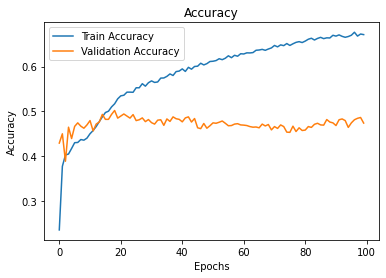

In [19]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

history.history['accuracy'][np.argmax(history.history['accuracy'])]

1.9685947895050049

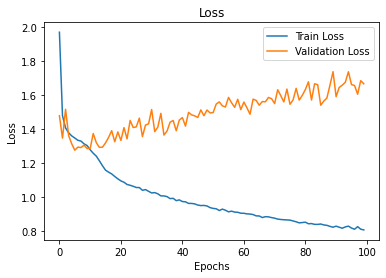

In [20]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

history.history['loss'][np.argmax(history.history['loss'])]

299.0


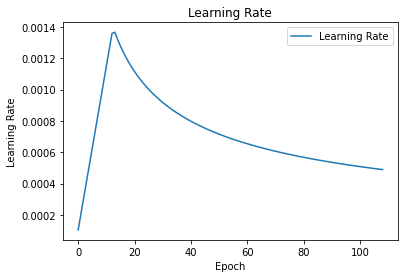

In [21]:
learning_rate = CustomSchedule(d_model)
steps_per_epoch = np.ceil((np.shape(X_train)[0]/batch_size))
print(steps_per_epoch)
lr = np.array([])
for i in range(1, np.maximum(epochs+10, 30)):
    lr = np.append(lr, learning_rate.__call__(i*steps_per_epoch))
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
plt.legend()


### Model Evaluation

In [23]:
epoch = np.argmax(history.history['val_accuracy'])
loss = history.history['loss'][epoch]
accuracy = history.history['accuracy'][epoch]
val_loss = history.history['val_loss'][epoch]
val_accuracy = history.history['val_accuracy'][epoch]
epoch += 1

print(f'best epoch: {epoch}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')

best epoch: 19, loss: 1.1225, accuracy: 0.5170, val_loss: 1.3263, val_accuracy: 0.5021


In [24]:
path = f"model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
print(path)
test_model = get_compiled_model()
test_model.build((19072,22))
test_model.load_weights(path)

model_weights/weights.epoch:[19]-val_acc:[0.50].hdf5


In [43]:
pred = test_model.predict(X_test)

68/68 [==============================] - 1s 10ms/step


In [44]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def un_norm_cm(norm_cm):
    np.array([
        cm[i] / np.sum(cm[i]) for i in range(len(cm))
    ])
    
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
def top_1_accuracy(cm):
    return (cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum()) / cm.sum()
def top_2_accuracy(cm):
    return (cm.diagonal(-2).sum() + cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum() +
                 cm.diagonal(2).sum()) / cm.sum()

In [45]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))
print('+-1 accuracy', top_1_accuracy(cm))
print('+-2 accuracy', top_2_accuracy(cm))

accuracy 0.48847926267281105
+-1 accuracy 0.8529953917050691
+-2 accuracy 0.971889400921659


Heatmap

<AxesSubplot:>

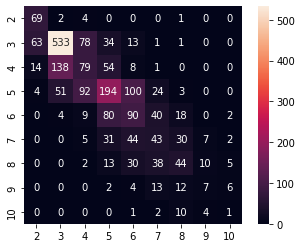

In [46]:
sns.heatmap(cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='g', square=True)

Normalized Heatmap

<AxesSubplot:>

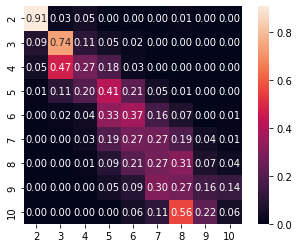

In [47]:
sns.heatmap(normalized_cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='.2f', square=True)